In [27]:
try:
    import torch
except:
    print("PyTorch not found. Please install it.")

In [28]:
from datetime import datetime
from ecallisto_ng.plotting.plotting import plot_spectogram_mpl, plot_spectogram
from ecallisto_ng.combine_antennas.combine import (
    preprocess_data,
    sync_spectrograms,
    match_spectrograms,
)
from ecallisto_ng.combine_antennas.utils import round_frequencies_to_nearest_bin
import pandas as pd
import numpy as np
from datetime import datetime
from ecallisto_ng.data_download.downloader import (
    get_ecallisto_data,
    get_instrument_with_available_data,
)

In [29]:
start_datetime = datetime(2021, 5, 7, 3, 35, 0)
end_datetime = datetime(2021, 5, 7, 3, 45, 0)

In [30]:
list = get_instrument_with_available_data(start_datetime, end_datetime)

In [31]:
list

['ALMATY_58',
 'ALMATY_59',
 'AUSTRIA-MICHELBACH_60',
 'AUSTRIA-OE3FLB_55',
 'AUSTRIA-OE3FLB_57',
 'AUSTRIA-UNIGRAZ_01',
 'Australia-ASSA_01',
 'Australia-ASSA_02',
 'Australia-ASSA_60',
 'Australia-LMRO_59',
 'BIR_01',
 'DENMARK_62',
 'DENMARK_63',
 'HURBANOVO_59',
 'INDIA-GAURI_59',
 'INDIA-IISERP_01',
 'INDIA-Nashik_59',
 'INDIA-OOTY_58',
 'INDIA-OOTY_59',
 'INDIA-UDAIPUR_01',
 'INDONESIA_59',
 'JAPAN-IBARAKI_59',
 'KASI_59',
 'KRIM_00',
 'MRO_59',
 'MRO_60',
 'MRO_61',
 'MRO_62',
 'MRT1_02',
 'MRT2_01',
 'MRT3_02',
 'NEWZEALAND-AUT_59',
 'NORWAY-NY-AALESUND_01',
 'NORWAY-RANDABERG_01',
 'SWISS-HEITERSWIL_59',
 'SWISS-Landschlacht_01',
 'SWISS-Landschlacht_02',
 'THAILAND-Pathumthani_62',
 'USA-ARIZONA-ERAU_58']

In [78]:
substrings_to_get = ['Australia-ASSA_01', 'Australia-ASSA_02']#'INDIA-OOTY', 'ALMATY_58']

In [79]:
# Download all available data
datas = []
for substring in substrings_to_get:
    dfs = get_ecallisto_data(start_datetime, end_datetime, substring, freq_start=23)
    if isinstance(dfs, dict):
        datas.extend(dfs.values())
    else:
        datas.append(dfs)

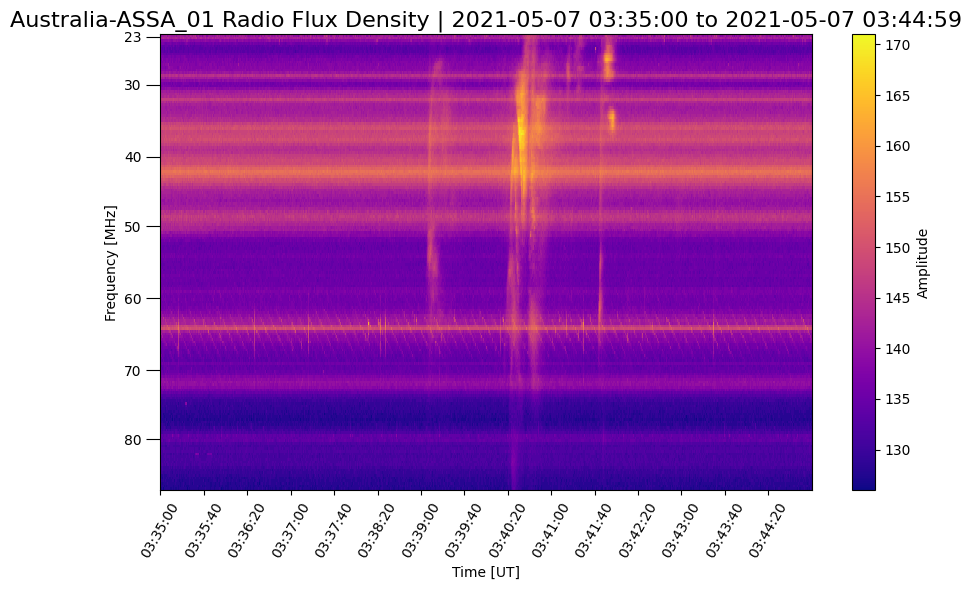

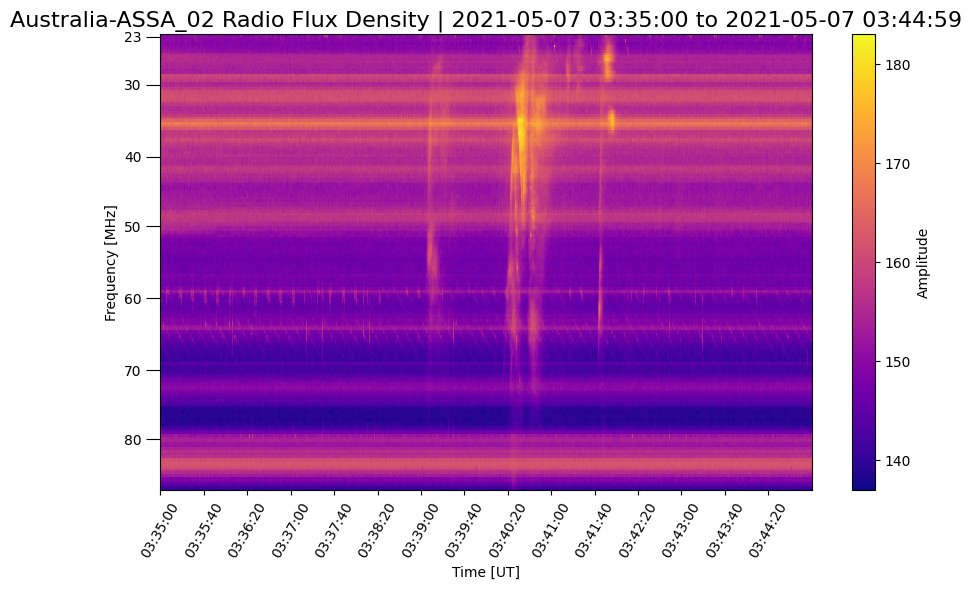

In [80]:
# Plot data
for data in datas:
    fig = plot_spectogram_mpl(data)

In [105]:
# Preprocess data
data_processed = preprocess_data(datas, min_n_frequencies=20, subtract_background=True, filter_type='median')

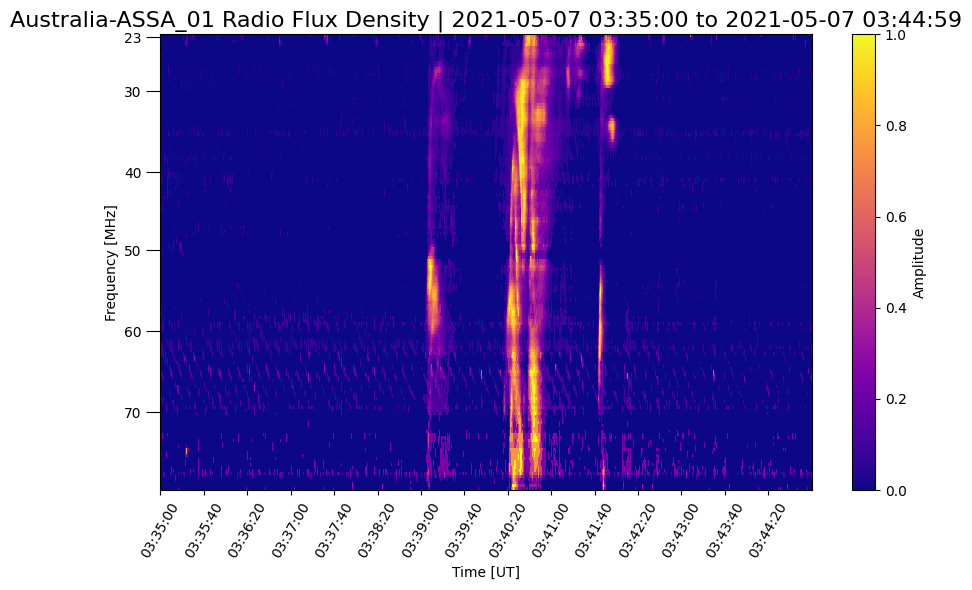

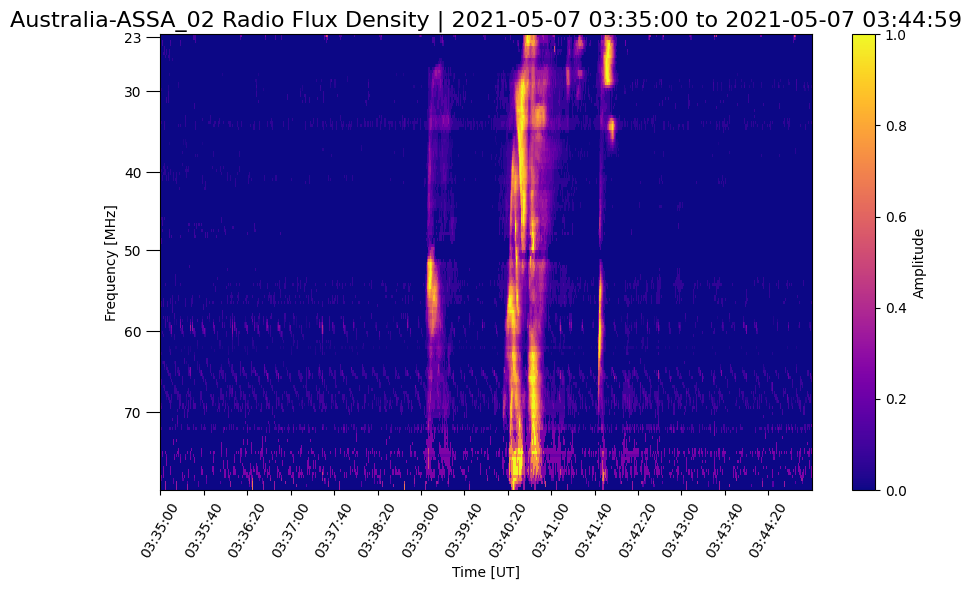

In [106]:
for data in data_processed:
    fig = plot_spectogram_mpl(data)

In [107]:
# Bin the frequencies. Not necessary but useful because the observed frequencies may vary a lot between the different antennas
data_binned = round_frequencies_to_nearest_bin(data_processed, 0.2)

In [108]:
matched_data = match_spectrograms(data_binned)

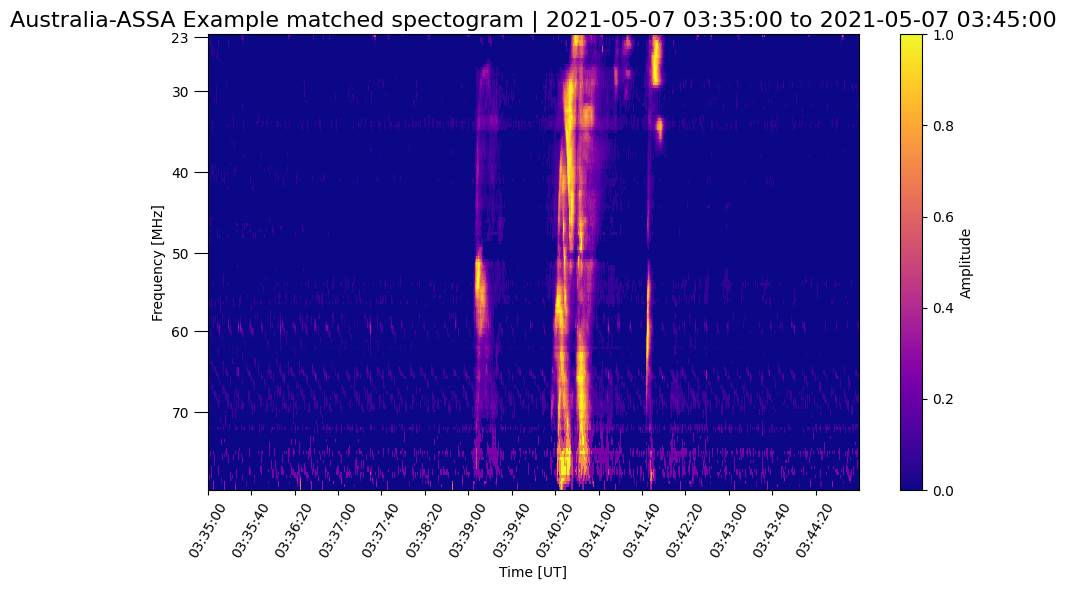

In [109]:
# Plot matched data
IDX_TO_PLOT = 1
fig = plot_spectogram_mpl(
    matched_data[1],
    matched_data[IDX_TO_PLOT].attrs["INSTRUME"],
    start_datetime,
    end_datetime,
    title="Example matched spectogram",
)

In [110]:
synced_data, ref_idx = sync_spectrograms(matched_data)

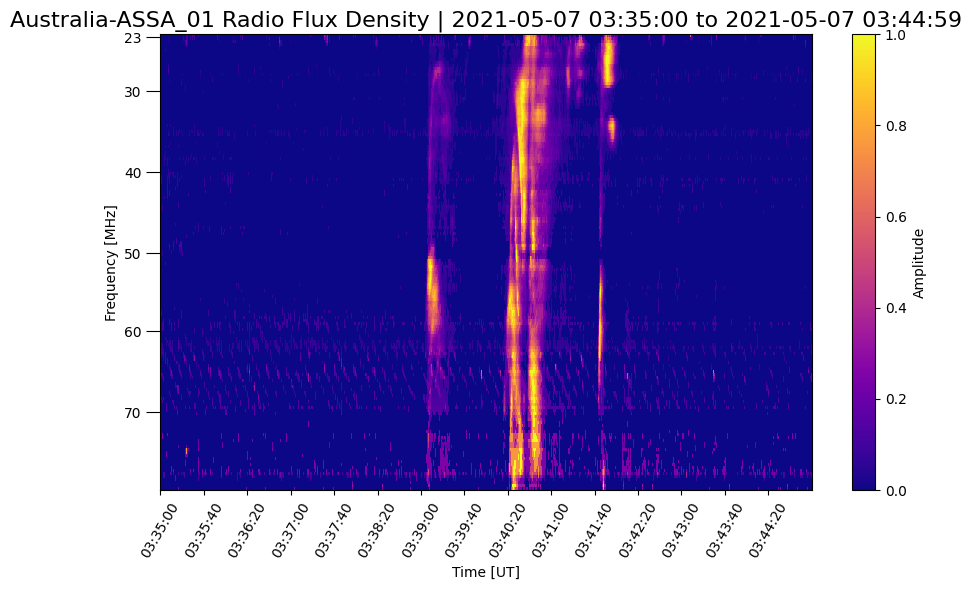

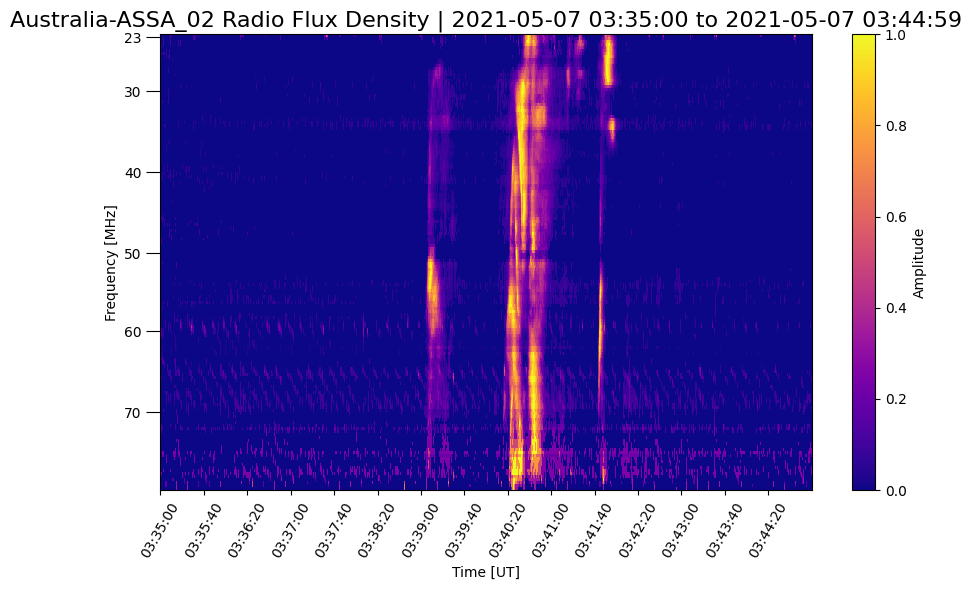

In [111]:
for data in synced_data:
    fig = plot_spectogram_mpl(data)

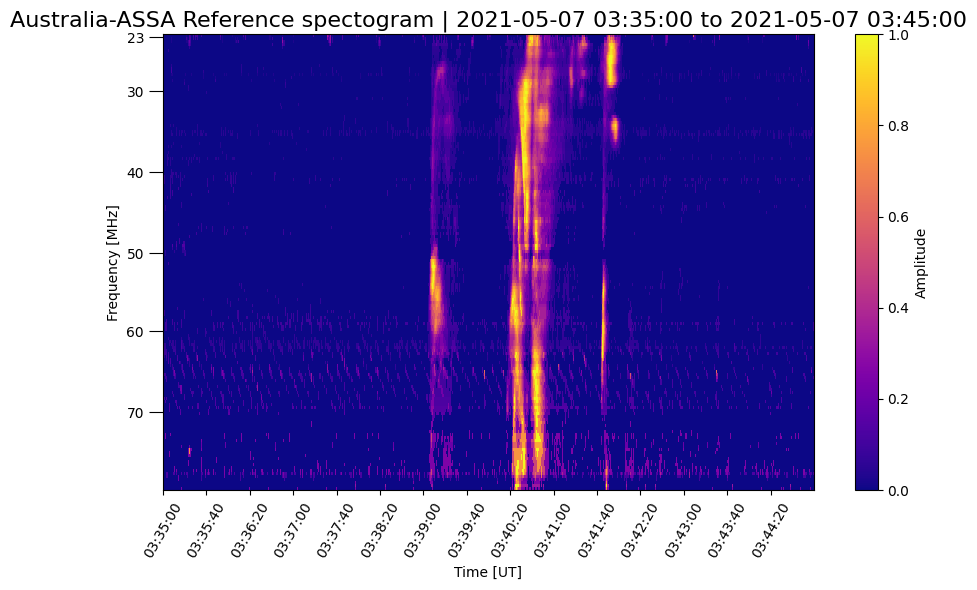

In [112]:
# Plot the spectogram, which most spectograms are in sync to
ref_spectogram_df = pd.DataFrame(
    synced_data[ref_idx], columns=synced_data[1].columns, index=synced_data[1].index
)
fig = plot_spectogram_mpl(
    synced_data[ref_idx],
    synced_data[ref_idx].attrs["INSTRUME"],
    start_datetime,
    end_datetime,
    title="Reference spectogram",
)

In [113]:
# Correlation with reference spectogram. Maybe we can do something with this?
def correlation_with_reference(spec_list, ref_idx):
    ref_spec = np.sum(spec_list[ref_idx], axis=1)
    correlations = []
    for spec in spec_list:
        correlations.append(np.corrcoef(ref_spec, np.sum(spec, axis=1))[0, 1])
    return correlations

In [114]:
corr_w_reference = correlation_with_reference(synced_data, ref_idx)
corr_w_reference

[1.0, 0.9982449264407243]

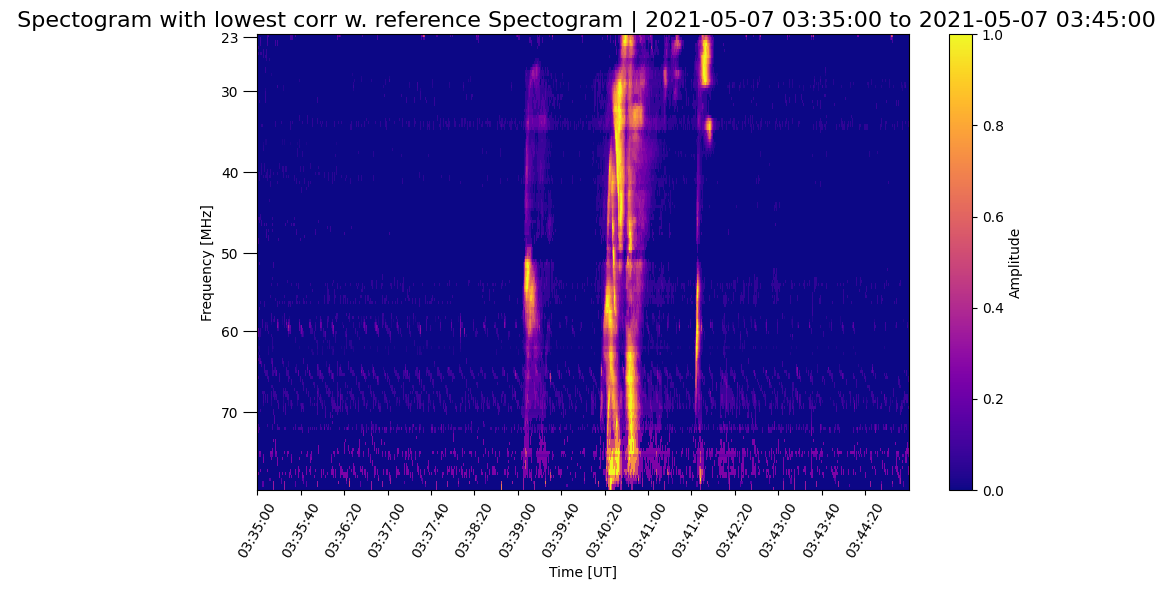

In [115]:
# Plot
fig = plot_spectogram_mpl(
    synced_data[np.argmin(corr_w_reference)],
    "",
    start_datetime,
    end_datetime,
    title="Spectogram with lowest corr w. reference Spectogram",
)

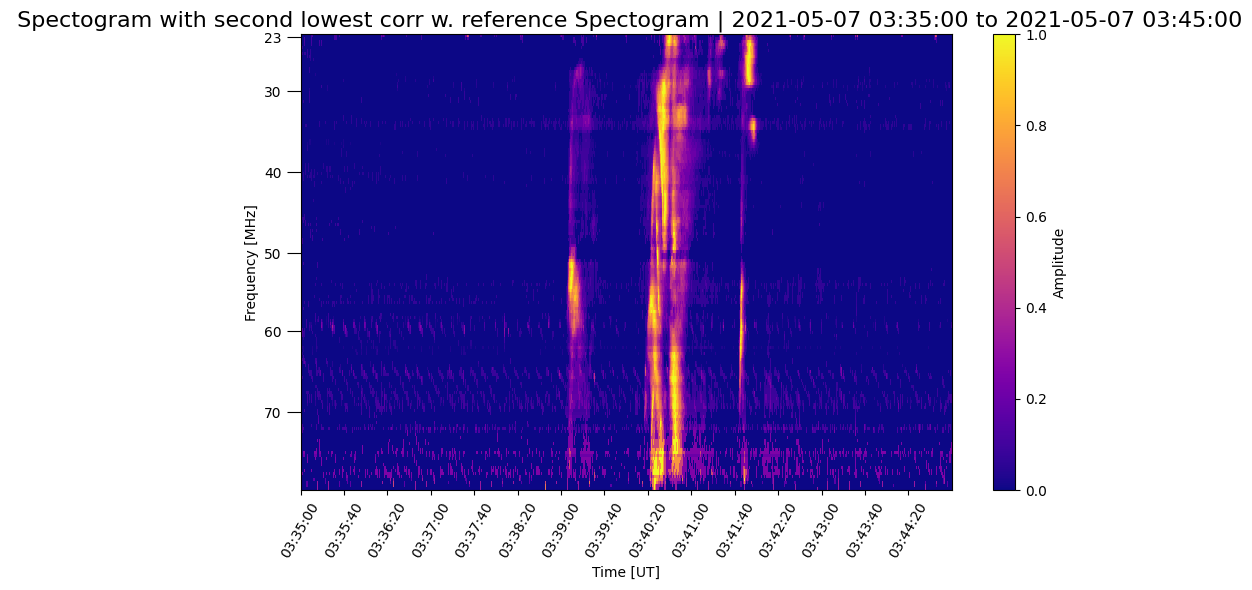

In [116]:
# Plot
fig = plot_spectogram_mpl(
    synced_data[-1],
    "",
    start_datetime,
    end_datetime,
    title="Spectogram with second lowest corr w. reference Spectogram",
)

In [117]:
# Calculate quantile of all matched and synced spectograms
QUANTILE = 0.6
##
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in synced_data])
torch_quantile = torch.nanquantile(torch_shifted, QUANTILE, dim=0)

## Super slow version with numpy quantile
# np.nanquantile(np.stack([df.values for df in synced_data]), QUANTILE, axis=0)

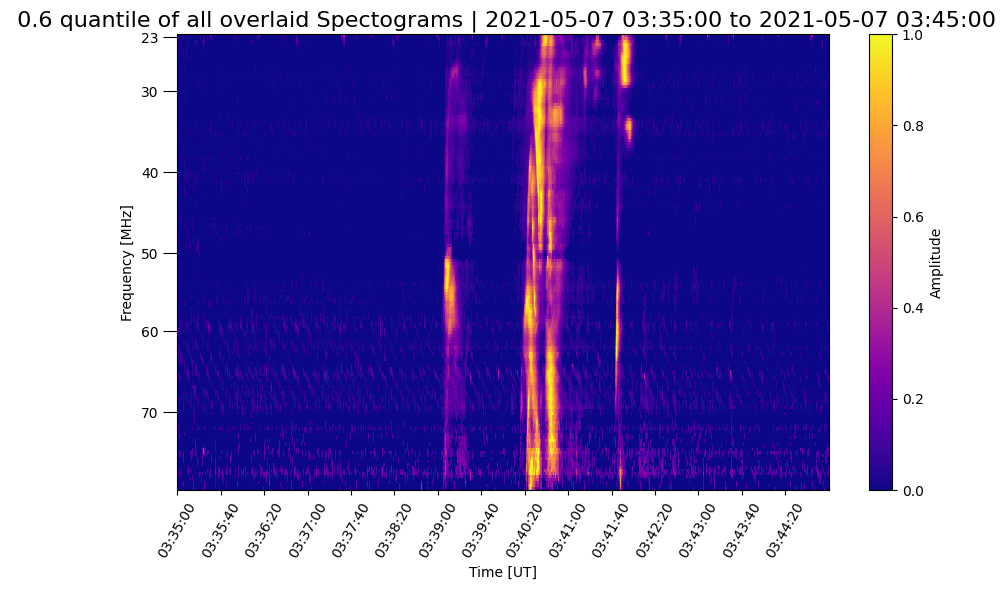

In [118]:
# Plot result
data_quantile_df = pd.DataFrame(
    torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index
)
fig = plot_spectogram_mpl(
    data_quantile_df,
    "",
    start_datetime,
    end_datetime,
    title=f"{QUANTILE} quantile of all overlaid Spectograms",
)

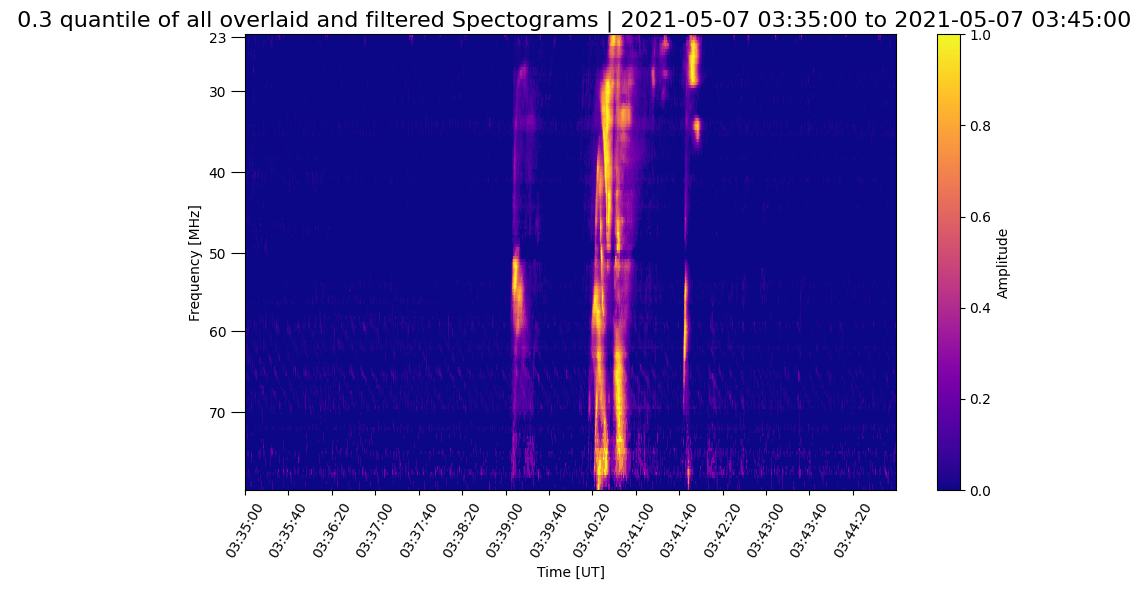

In [122]:
# Filter out all spectograms with correlation below a certain threshold
CORR_THRESHOLD = 0.3
QUANTILE = 0.3

## Filter by corr
idx_to_keep = np.where(np.array(corr_w_reference) > CORR_THRESHOLD)[0]
synced_data_filtered = [synced_data[idx] for idx in idx_to_keep]
torch_corr = torch.stack([torch.from_numpy(df.values) for df in synced_data_filtered])

# Caculate quantile
torch_shifted = torch.stack([torch.from_numpy(df.values) for df in synced_data])
torch_quantile = torch.nanquantile(torch_shifted, QUANTILE, dim=0)

# Plot result
data_quantile_df = pd.DataFrame(
    torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index
)
fig = plot_spectogram_mpl(
    data_quantile_df,
    "",
    start_datetime,
    end_datetime,
    title=f"{QUANTILE} quantile of all overlaid and filtered Spectograms",
)

In [123]:
FROM = datetime(2021, 5, 7, 3, 40, 0)
TO = datetime(2021, 5, 7, 3, 41, 16)

In [124]:
data_quantile_df = pd.DataFrame(
    torch_quantile, columns=synced_data[1].columns, index=synced_data[1].index
)

data_quantile_df = data_quantile_df.loc[FROM:TO]
plot_spectogram(
    data_quantile_df,
    "",
    start_datetime,
    end_datetime,
    title=f"SOL2021-05-07T03:39, as seen by multiple antennas",
)